# 1) Import Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import PIL
import os

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from scipy import stats

from google.cloud import bigquery
from pathlib import Path
from PIL import Image

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

from sklearn import set_config; set_config(display='diagram')

from tensorflow import keras
from keras import Model, Sequential, layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.metrics import mean_absolute_error

random_seed = 42
np.random.seed(random_seed)

# 2) Load Data

In [2]:
# Environmental Variables

LOCAL_DATA_PATH = Path('~').joinpath("OneDrive", "11_MLOps", "taxifare", "data").expanduser()
GCP_PROJECT = "taxifare-mlops"
BQ_DATASET = "chicagotaxi"
TABLE = "rides"
DATA_SIZE = 200000 

In [3]:
# Query

# client = bigquery.Client(project=GCP_PROJECT, location='US') 

selected_columns = ['trip_start_timestamp', 'fare',  
                    'pickup_latitude', 'pickup_longitude', 
                    'dropoff_latitude', 'dropoff_longitude', ]


query = f"""
    SELECT {', '.join(selected_columns)}
    FROM {GCP_PROJECT}.{BQ_DATASET}.{TABLE}
    ORDER BY trip_start_timestamp DESC
    LIMIT {DATA_SIZE}
    """


print(query)


    SELECT trip_start_timestamp, fare, pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude
    FROM taxifare-mlops.chicagotaxi.rides
    ORDER BY trip_start_timestamp DESC
    LIMIT 200000
    


In [4]:
# Get Data

data_query_cache_path = Path(LOCAL_DATA_PATH).joinpath("raw", f"query_{DATA_SIZE}.csv")

if data_query_cache_path.is_file():
    print("load local file...")
    df = pd.read_csv(data_query_cache_path, parse_dates=['trip_start_timestamp'])
    print("Data are ready!")
    
else:
    print("Querying Big Query server...")
   
    client = bigquery.Client(project=GCP_PROJECT)
    query_job = client.query(query)
    result = query_job.result() 
    df = result.to_dataframe()
    
    df.to_csv(data_query_cache_path, header=True, index=False)
    
    print("Data are ready!")

Querying Big Query server...
Data are ready!


In [5]:
df

,trip_start_timestamp,fare,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,2023-09-01 00:00:00+00:00,43.75,41.980264,-87.913625,41.874005,-87.663518
1,2023-09-01 00:00:00+00:00,17.75,41.792592,-87.769615,NaN,NaN
2,2023-09-01 00:00:00+00:00,32.48,41.899602,-87.633308,41.763247,-87.616134
3,2023-09-01 00:00:00+00:00,9.98,41.922686,-87.649489,41.899602,-87.633308
4,2023-09-01 00:00:00+00:00,28.75,41.878866,-87.625192,42.009623,-87.670167
...,...,...,...,...,...,...
199995,2023-08-20 11:00:00+00:00,4.75,41.899602,-87.633308,41.899602,-87.633308
199996,2023-08-20 11:00:00+00:00,4.25,41.785999,-87.750934,41.785999,-87.750934
199997,2023-08-20 11:00:00+00:00,51.56,NaN,NaN,41.761578,-87.572782
199998,2023-08-20 11:00:00+00:00,4.00,41.899602,-87.633308,41.899602,-87.633308


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   trip_start_timestamp  200000 non-null  datetime64[ns, UTC]
 1   fare                  199507 non-null  float64            
 2   pickup_latitude       194202 non-null  float64            
 3   pickup_longitude      194202 non-null  float64            
 4   dropoff_latitude      181865 non-null  float64            
 5   dropoff_longitude     181865 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5)
memory usage: 9.2 MB


## 2.1) Compress Data

In [7]:
def compress(df, **kwargs):
    """
    Reduces the size of the DataFrame by downcasting numerical columns
    """
    input_size = df.memory_usage(index=True).sum()/ 1024**2
    print("old dataframe size: ", round(input_size,2), 'MB')
    
    in_size = df.memory_usage(index=True).sum()

    for t in ["float"]:
        l_cols = list(df.select_dtypes(include=t))

        for col in l_cols:
            df[col] = pd.to_numeric(df[col], downcast=t)

    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100
    
    print("optimized size by {} %".format(round(ratio,2)))
    print("new DataFrame size: ", round(out_size / 1024**2,2), " MB")

    return df

In [8]:
df = compress(df, verbose=True)
df.head(1)

old dataframe size:  9.16 MB
optimized size by 42.0 %
new DataFrame size:  5.34  MB


,trip_start_timestamp,fare,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,2023-09-01 00:00:00+00:00,43.75,41.980263,-87.913628,41.874004,-87.663521


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   trip_start_timestamp  200000 non-null  datetime64[ns, UTC]
 1   fare                  199507 non-null  float32            
 2   pickup_latitude       194202 non-null  float32            
 3   pickup_longitude      194202 non-null  float32            
 4   dropoff_latitude      181865 non-null  float32            
 5   dropoff_longitude     181865 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(5)
memory usage: 5.3 MB


# 3) Exploratory Data Analysis

## 3.1) Clean Data

In [10]:
# Drop NaN, duplicates and 0 values in the lat/long

print(f"Nr of rows before cleaning {df.shape[0]}")

df = df.drop_duplicates()
df = df.dropna(how='any', axis=0)
df = df[(df.dropoff_latitude != 0) | (df.dropoff_longitude != 0) | (df.pickup_latitude != 0) | (df.pickup_longitude != 0)]

print(f"Nr of rows before cleaning {df.shape[0]}")

Nr of rows before cleaning 200000
Nr of rows before cleaning 174033


## 3.2) Visualize Data

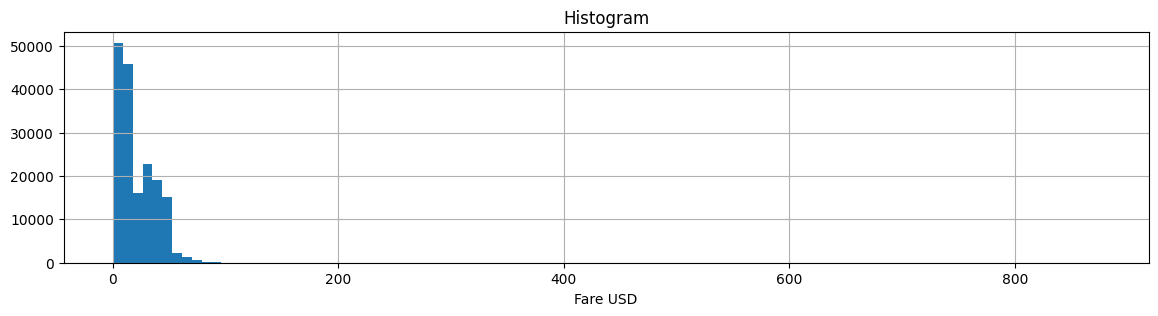

In [11]:
# Plot histogram of fare

df.fare.hist(bins=100, figsize=(14,3))

plt.xlabel('Fare USD')
plt.title('Histogram')

# Display the box plot
plt.show()

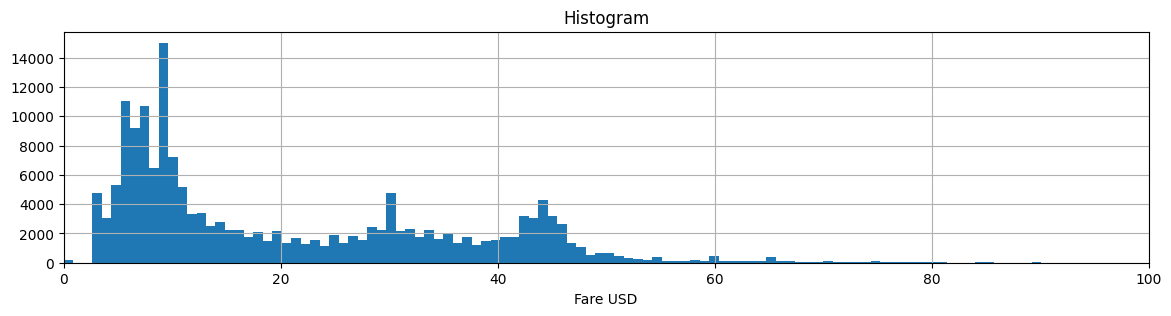

In [12]:
# Plot histogram of fare in the 100 fare

df.fare.hist(bins=1000, figsize=(14,3))

plt.xlabel('Fare USD')
plt.title('Histogram')
plt.xlim((0,100))

# Display the box plot
plt.show()

We see that most of the parameters are concentrated in the first 100 USD and the 75 % IQR is 32.5. We also see a positive skewness and a multimodal distribution

In [13]:
df.describe()

,fare,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,174033.000000,174033.000000,174033.000000,174033.000000,174033.000000
mean,20.864910,41.899715,-87.692032,41.894009,-87.661682
std,16.597345,0.061500,0.107484,0.056874,0.072363
min,0.000000,41.660137,-87.913628,41.660137,-87.913628
25%,7.750000,41.878864,-87.695015,41.878864,-87.663521
50%,13.750000,41.892509,-87.633972,41.892071,-87.633308
75%,32.750000,41.944225,-87.625191,41.922688,-87.625191
max,875.000000,42.015934,-87.534904,42.016010,-87.534904


## 3.3) Outliers

In [14]:
# Compute z-score to remove outliers

# Sample data (replace with your own dataset)
data = np.array(df['fare'])

# Calculate the z-scores for the data
z_scores = stats.zscore(data)

# Define a z-score threshold for identifying outliers
z_score_threshold = 2  # You can adjust this threshold as needed

# Identify outliers by checking if the absolute z-score is greater than the threshold
outliers = np.where(np.abs(z_scores) > z_score_threshold)

print("Z-scores:", z_scores)
print("Outliers:", data[outliers])

Z-scores: [ 1.3788444   0.69981813 -0.65582424 ... -0.97093576 -1.0010612
 -1.0161239 ]
Outliers: [60.  55.  56.  ... 68.  72.5 55. ]


In [15]:
df_filtered = df[np.abs(stats.zscore(df['fare'])) <= z_score_threshold]

In [16]:
df_filtered.describe()

,fare,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,170024.000000,170024.000000,170024.000000,170024.000000,170024.000000
mean,19.740572,41.899052,-87.689575,41.894028,-87.660316
std,14.346992,0.060940,0.105665,0.056168,0.070087
min,0.000000,41.660137,-87.913628,41.660137,-87.913628
25%,7.750000,41.878864,-87.687515,41.878864,-87.663414
50%,13.210000,41.892509,-87.633308,41.892071,-87.633308
75%,31.500000,41.944225,-87.625191,41.922688,-87.625191
max,54.000000,42.015934,-87.534904,42.016010,-87.534904


In [17]:
df_filtered.fare.max()

54.0

In [18]:
# Remove transactions above z-score values

df = df[(df.fare > 0) & (df.fare < df_filtered.fare.max())]

In [19]:
df.describe()

,fare,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,169840.000000,169840.000000,169840.000000,169840.000000,169840.000000
mean,19.746059,41.899059,-87.689560,41.894028,-87.660271
std,14.331998,0.060931,0.105669,0.056152,0.070047
min,0.010000,41.660137,-87.913628,41.660137,-87.913628
25%,7.750000,41.878864,-87.687515,41.878864,-87.663414
50%,13.250000,41.892509,-87.633308,41.892071,-87.633308
75%,31.500000,41.944225,-87.625191,41.922688,-87.625191
max,53.939999,42.015934,-87.534904,42.016010,-87.534904


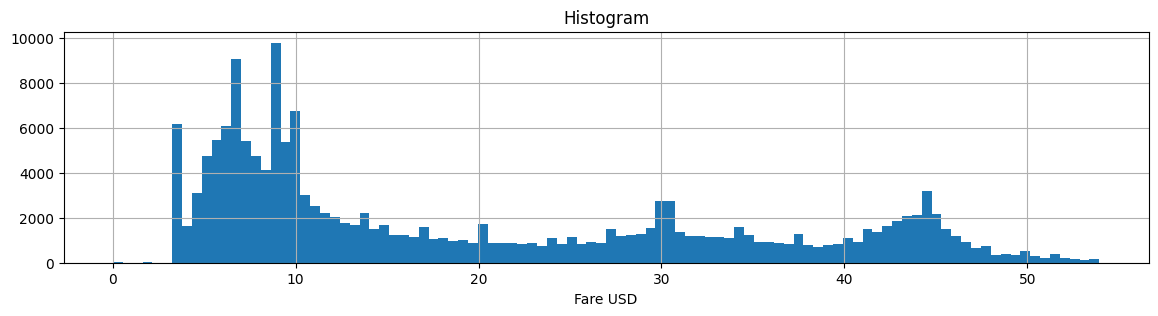

In [20]:
# Plot histogram of fare without outliers

df.fare.hist(bins=100, figsize=(14,3))

plt.xlabel('Fare USD')
plt.title('Histogram')


# Display the box plot
plt.show()

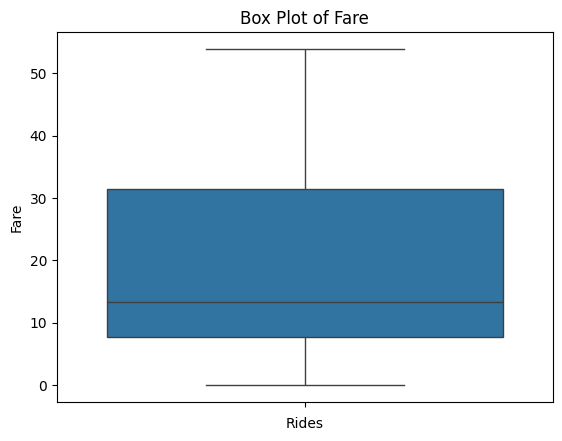

In [21]:
# Boxplot 

# Create a box plot for the 'Fare' column
sns.boxplot(df['fare'])

# Add labels and title
plt.xlabel('Rides')
plt.ylabel('Fare')
plt.title('Box Plot of Fare')

# Display the box plot
plt.show()

## 3.4) Plot Data on Map

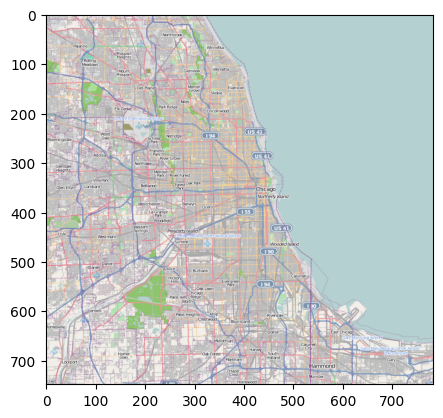

In [22]:
# Load the image of the city

chicago_map = Image.open('Chicago_Map.png')

# Display the image
plt.imshow(chicago_map)

plt.show()

In [23]:
# Function to plot data on the city map

def plot_on_map(df, BB, chicago_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))

    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='red', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(chicago_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='blue', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(chicago_map, zorder=0, extent=BB)

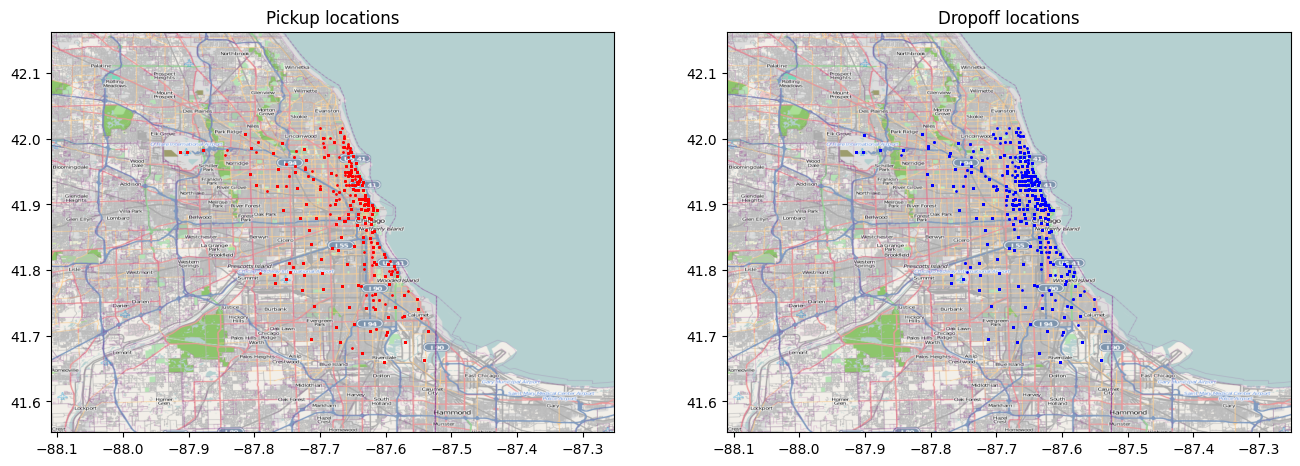

In [24]:
# Plot training data on map

bounding_boxes = (-88.11, -87.252, 41.553, 42.163)

plot_on_map(df, bounding_boxes, chicago_map, s=1, alpha=1)

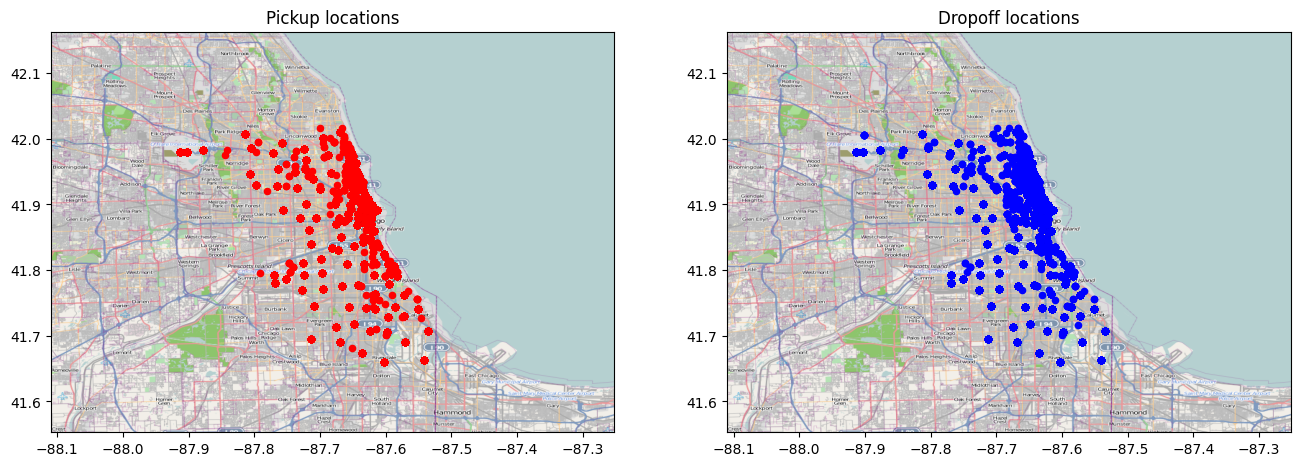

In [25]:
# Plot training data on map

bounding_boxes = (-88.11, -87.252, 41.553, 42.163)

plot_on_map(df, bounding_boxes, chicago_map, s=20, alpha=1)

## 3.5) Visualize Distance

To plot the distance distribution, we will calculate the vectorized Manhattan distance between each ride.

In [26]:
def manhattan_distance_vectorized(df: pd.DataFrame, start_lat: str, start_lon: str, end_lat: str, end_lon: str) -> dict:
    """
    Calculate the Manhattan distance in km between two points on the earth (specified in decimal degrees).
    Vectorized version for pandas df
    """
    earth_radius = 6371
    
    lat_1_rad, lon_1_rad = np.radians(df[start_lat]), np.radians(df[start_lon])
    lat_2_rad, lon_2_rad = np.radians(df[end_lat]), np.radians(df[end_lon])
    
    dlon_rad = lon_2_rad - lon_1_rad
    dlat_rad = lat_2_rad - lat_1_rad
    
    manhattan_rad = np.abs(dlon_rad) + np.abs(dlat_rad)
    manhattan_km = manhattan_rad * earth_radius
    
    return manhattan_km

We see most of the distances up to 50 km.

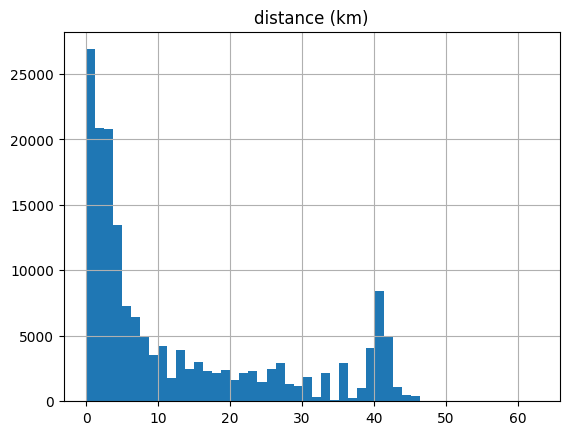

In [27]:
manhattan_distance_vectorized(df, "pickup_latitude", "pickup_longitude","dropoff_latitude", "dropoff_longitude").hist(bins=50)
plt.title("distance (km)")

plt.show();

# 4) Model

## 4.1) Train/Val/Test Split

In [28]:
# Train/Test Split


# Shuffle the DataFrame with the specified random seed
df = df.sample(frac=1, random_state=random_seed)

# Select Target
X = df.drop("fare", axis=1)
y = df[["fare"]]

# Split the data into train, validation, and test sets (80% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=random_seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed)

# Print the shapes of the resulting DataFrames
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(118888, 5)
(25476, 5)
(25476, 5)


## 4.2) Baseline Model

Let's calculate a baseline model based only on the distance

In [29]:
distances_train = np.array(manhattan_distance_vectorized(X_train, "pickup_latitude", "pickup_longitude","dropoff_latitude", "dropoff_longitude"))
distances_val = np.array(manhattan_distance_vectorized(X_val, "pickup_latitude", "pickup_longitude","dropoff_latitude", "dropoff_longitude"))
distances_test = np.array(manhattan_distance_vectorized(X_test, "pickup_latitude", "pickup_longitude","dropoff_latitude", "dropoff_longitude"))

In [30]:
# Baseline Model: Linear regression

baseline_model = LinearRegression()

baseline_model.fit(distances_train[:, None], y_train)

LinearRegression()

In [31]:
baseline_pred_val = baseline_model.predict(distances_val[:, None])

baseline_pred_test = baseline_model.predict(distances_test[:, None])

baseline_mae_val = np.mean(np.abs(baseline_pred_val - y_val), axis=0)

baseline_mae_test = np.mean(np.abs(baseline_pred_test - y_test), axis=0)

print(f'Mean taxifare prices on train set = {round(float(np.mean(y_train.iloc[:, 0])), 2)} USD')
print(f'Baseline MAE on val set = {round(float(baseline_mae_val.iloc[0]), 2)} USD')
print(f'Baseline MAE on test set = {round(float(baseline_mae_test.iloc[0]), 2)} USD')


Mean taxifare prices on train set = 19.72 USD
Baseline MAE on val set = 3.88 USD
Baseline MAE on test set = 3.83 USD


## 4.3) Preprocessing Pipeline

Now we will preprocess all features. The distance using the vectorized Manhattan and an additional Haversine distance and the time using encoding 

### 4.4.1) Time Preprocessor

Let's extract interesting attributes from the `trip_start_timestamp`
- hour of the day
- day of the week
- month of the year
- number of days

In [32]:
# Transform time features

def transform_time_features(X: pd.DataFrame) -> np.ndarray:
    
    # Find the oldest time in the DataFrame to use as a reference point
    reference_time = X["trip_start_timestamp"].min()
    
    # Calculate the time difference in days from the oldest time
    timedelta = (X["trip_start_timestamp"] - reference_time) / pd.Timedelta(1, 'D')
    
    # Extract additional time-related features from "trip_start_timestamp"
    pickup_dt = X["trip_start_timestamp"].dt.tz_convert("America/Chicago").dt
    dow = pickup_dt.weekday
    hour = pickup_dt.hour
    month = pickup_dt.month
    
    # Encode the hour of the day using sine and cosine to capture cyclic patterns
    hour_sin = np.sin(2 * math.pi / 24 * hour)
    hour_cos = np.cos(2 * math.pi / 24 * hour)
    
    # Stack the extracted features horizontally into a NumPy array
    feature_array = np.stack([hour_sin, hour_cos, dow, month, timedelta], axis=1)
    
    return feature_array

# Call the transform_time_features function with the "trip_start_timestamp" column
X_time_processed = transform_time_features(X[["trip_start_timestamp"]])

# Create a DataFrame with the processed time-related features
processed_df = pd.DataFrame(X_time_processed, columns=["hour_sin", "hour_cos", "dow", "month", "timedelta"])

# Display the last 200 rows of the processed DataFrame
processed_df.tail(200)

,hour_sin,hour_cos,dow,month,timedelta
169640,5.000000e-01,-0.866025,4.0,8.0,5.197917
169641,5.000000e-01,-0.866025,3.0,8.0,4.177083
169642,5.000000e-01,-0.866025,3.0,8.0,4.166667
169643,8.660254e-01,-0.500000,6.0,8.0,0.083333
169644,8.660254e-01,-0.500000,2.0,8.0,10.083333
...,...,...,...,...,...
169835,1.224647e-16,-1.000000,2.0,8.0,3.270833
169836,1.224647e-16,-1.000000,3.0,8.0,4.250000
169837,-9.659258e-01,0.258819,1.0,8.0,2.541667
169838,-5.000000e-01,0.866025,0.0,8.0,1.697917


And combine this with a sort of "Min-Max" re-scaling of the `timedelta` column

In [33]:
# One hot encoding of day and month

time_categories = [np.arange(0, 7, 1),   # days of the week from 0 to 6
                   np.arange(1, 13, 1)]  # months of the year from 1 to 12

OneHotEncoder(categories=time_categories, sparse_output=False)\
                        .fit_transform(X_time_processed[:,[2,3]]) # column index [2,3] for ['dow', 'month'] 


time_pipe = make_pipeline(
    FunctionTransformer(transform_time_features),
    make_column_transformer(
        (OneHotEncoder(
            categories=time_categories,
            sparse_output=False,
            handle_unknown="ignore"
        ), [2, 3]),
        (MinMaxScaler(), [4]),  
        remainder="passthrough"
    )
)



preprocessor = ColumnTransformer(
    [
        ("time_preproc", time_pipe, ["trip_start_timestamp"]),
    ],
)

preprocessor

ColumnTransformer(transformers=[('time_preproc',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function transform_time_features at 0x0000016DC9E395A0>)),
                                                 ('columntransformer',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('onehotencoder',
                                                                                   OneHotEncoder(categories=[array([0, 1, 2, 3, 4, 5, 6]),
                                                                                                             array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])],
                                                                                                 handle_unknown='ignore',
                                                                                                 sparse_output=False),
                                                                                   [2,
                                                                                    3]),
                                                                                  ('minmaxscaler',
                                                                                   MinMaxScaler(),
                                                                                   [4])]))]),
                                 ['trip_start_timestamp'])])

In [34]:
X_train.head()

,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
129733,2023-08-24 11:15:00+00:00,41.880993,-87.632744,41.884987,-87.620995
133504,2023-08-24 07:45:00+00:00,41.922688,-87.649490,41.878864,-87.625191
8408,2023-08-31 15:30:00+00:00,41.880993,-87.632744,41.898331,-87.620766
56421,2023-08-28 19:45:00+00:00,41.874004,-87.663521,41.874004,-87.663521
191206,2023-08-20 21:00:00+00:00,41.878864,-87.625191,41.899601,-87.633308


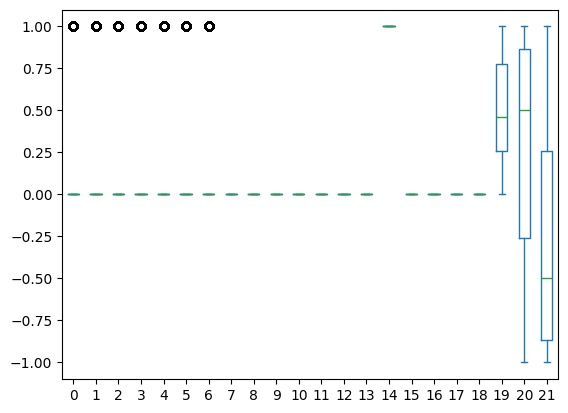

In [35]:
# Check scaling and nr of features

pd.DataFrame(preprocessor.fit_transform(X_train)).plot(kind='box');

### 4.4.2) Distance Pipeline

Let's add both the haversine and Manhattan distances as features

In [36]:
lonlat_features = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]

In [37]:
def distances_vectorized(df: pd.DataFrame, start_lat: str, start_lon: str, end_lat: str, end_lon: str) -> dict:
    """
    Calculate the haversine and Manhattan distances between two points (specified in decimal degrees).
    Vectorized version for pandas df
    Computes distance in Km
    """
    earth_radius = 6371

    lat_1_rad, lon_1_rad = np.radians(df[start_lat]), np.radians(df[start_lon])
    lat_2_rad, lon_2_rad = np.radians(df[end_lat]), np.radians(df[end_lon])

    dlon_rad = lon_2_rad - lon_1_rad
    dlat_rad = lat_2_rad - lat_1_rad

    manhattan_rad = np.abs(dlon_rad) + np.abs(dlat_rad)
    manhattan_km = manhattan_rad * earth_radius

    a = (np.sin(dlat_rad / 2.0)**2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon_rad / 2.0)**2)
    haversine_rad = 2 * np.arcsin(np.sqrt(a))
    haversine_km = haversine_rad * earth_radius

    return dict(
        haversine = haversine_km,
        manhattan = manhattan_km
    )

In [38]:
def transform_lonlat_features(X:pd.DataFrame)-> pd.DataFrame:

    res = distances_vectorized(X, *lonlat_features)

    return pd.DataFrame(res)

distances = transform_lonlat_features(X[lonlat_features])
distances

,haversine,manhattan
132296,0.000000,0.000000
61220,0.000000,0.000000
120851,9.032622,12.659052
118588,24.839296,40.407501
125298,16.584320,21.408669
...,...,...
140727,1.069240,1.750607
121832,19.435633,25.924171
154773,4.753174,7.760391
172198,17.364141,27.132507


In [39]:
# Pipeline

distance_pipe = make_pipeline(
    FunctionTransformer(transform_lonlat_features),
    RobustScaler()  
)

preprocessor = ColumnTransformer(
    [
        ("dist_preproc", distance_pipe, lonlat_features),
    ],
)
preprocessor

ColumnTransformer(transformers=[('dist_preproc',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function transform_lonlat_features at 0x0000016DCD7C6EF0>)),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['pickup_latitude', 'pickup_longitude',
                                  'dropoff_latitude', 'dropoff_longitude'])])

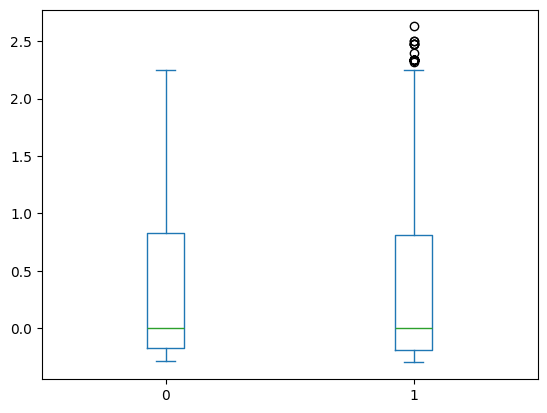

In [40]:
# Check scaling and nr of features

X_processed = pd.DataFrame(preprocessor.fit_transform(X_train))
X_processed.plot(kind='box');

### 4.4.3) Full Preprocessing Pipeline

Let's put all together

In [41]:
# Full Pipeline


# DISTANCE PIPE
distance_pipe = make_pipeline(
    FunctionTransformer(transform_lonlat_features),
    RobustScaler()  
)



# TIME PIPE
time_pipe = make_pipeline(
    FunctionTransformer(transform_time_features),
    make_column_transformer(
        (OneHotEncoder(
            categories=time_categories,
            sparse_output=False,
            handle_unknown="ignore"
        ), [2, 3]),
        (MinMaxScaler(), [4]),  
        remainder="passthrough"
    )
)



# COMBINED PREPROCESSOR
final_preprocessor = ColumnTransformer(
    [
        ("time_preproc", time_pipe, ["trip_start_timestamp"]),
        ("dist_preproc", distance_pipe, lonlat_features),
    ],
    n_jobs=-1,
)

In [42]:
final_preprocessor

ColumnTransformer(n_jobs=-1,
                  transformers=[('time_preproc',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function transform_time_features at 0x0000016DC9E395A0>)),
                                                 ('columntransformer',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('onehotencoder',
                                                                                   OneHotEncoder(categories=[array([0, 1, 2, 3, 4, 5, 6]),
                                                                                                             array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 1...
                                                                                                 handle_unknown='ignore',
                                                                                                 sparse_output=False),
                                                                                   [2,
                                                                                    3]),
                                                                                  ('minmaxscaler',
                                                                                   MinMaxScaler(),
                                                                                   [4])]))]),
                                 ['trip_start_timestamp']),
                                ('dist_preproc',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function transform_lonlat_features at 0x0000016DCD7C6EF0>)),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['pickup_latitude', 'pickup_longitude',
                                  'dropoff_latitude', 'dropoff_longitude'])])

In [43]:
# Fit the features

final_preprocessor.fit(X_train)

X_train_processed = final_preprocessor.transform(X_train)
X_val_processed = final_preprocessor.transform(X_val)
X_test_processed = final_preprocessor.transform(X_test)

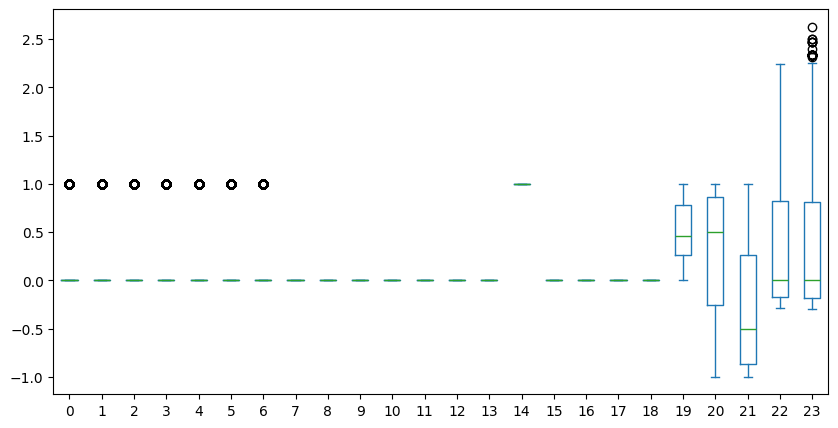

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))
pd.DataFrame(X_train_processed).plot(kind='box', ax=ax);

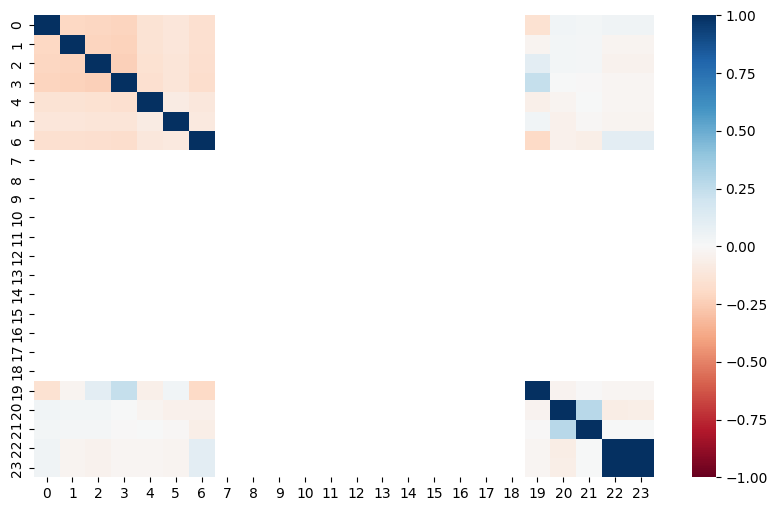

In [45]:
# Heatmap correlations

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(pd.DataFrame(X_train_processed).corr(), vmin=-1, cmap='RdBu');

In [46]:
# Compress the data a bit

X_train_processed = X_train_processed.astype(np.float32)
X_val_processed = X_val_processed.astype(np.float32)
X_test_processed = X_test_processed.astype(np.float32)

print(X_train_processed.nbytes / 1024**2, "MB")

10.884521484375 MB


In [47]:
pd.DataFrame(X_train_processed)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.347473,1.000000e+00,6.123234e-17,-0.207822,-0.204531
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.334838,5.000000e-01,8.660254e-01,0.113318,0.109085
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.969314,5.000000e-01,-8.660254e-01,-0.123873,-0.123295
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.724729,-5.000000e-01,-8.660254e-01,-0.289532,-0.298792
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.036101,-8.660254e-01,-5.000000e-01,-0.105990,-0.126015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118883,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.715704,1.224647e-16,-1.000000e+00,1.727233,2.035250
118884,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.281588,1.224647e-16,-1.000000e+00,-0.215668,-0.224876
118885,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.293321,-7.071068e-01,-7.071068e-01,-0.164716,-0.182735
118886,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.272563,7.071068e-01,-7.071068e-01,-0.224814,-0.247551


In [48]:
pd.DataFrame(X_train_processed).describe().mean(axis=1)

count    118888.000000
mean          0.130548
std           0.224467
min          -0.066180
25%          -0.009459
50%           0.060996
75%           0.189272
max           0.661349
dtype: float64

## 4.4) Advanced Model

### 4.4.1) Neural Network

In [49]:
def initialize_model(input_shape: tuple):
    """
    Initialize an improved Neural Network model.
    """

    model = Sequential()

    # Input layer
    model.add(Dense(256, activation="relu", input_shape=input_shape))
    model.add(BatchNormalization(momentum=0.9))

    # Hidden layers
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.2))  # Dropout regularization

    # Add more hidden layers as needed
    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(1, activation="linear"))

    return model


In [50]:
# Initialize model

tf.random.set_seed(random_seed)

model_nn = initialize_model(input_shape=X_train_processed.shape[1:])

model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               6400      
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                        

In [51]:
# Train the model

batch_size = 256
lr = 0.001

optimizer = keras.optimizers.Adam(learning_rate = lr)
model_nn.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])

callbacks = [EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=0),
             ReduceLROnPlateau(factor=0.2, patience=2, monitor='val_loss')]

history = model_nn.fit(
                    X_train_processed,
                    y_train,
                    validation_data=(X_val_processed, y_val),
                    epochs=100,
                    batch_size=batch_size,
                    callbacks=callbacks,
                    verbose=1
                )

Epoch 1/100
465/465 [==============================] - 3s 4ms/step - loss: 91.0668 - mae: 6.3173 - val_loss: 31.9998 - val_mae: 3.2476 - lr: 0.0010
Epoch 2/100
465/465 [==============================] - 1s 3ms/step - loss: 43.0785 - mae: 4.3189 - val_loss: 31.9132 - val_mae: 3.2667 - lr: 0.0010
Epoch 3/100
465/465 [==============================] - 2s 4ms/step - loss: 41.7699 - mae: 4.2315 - val_loss: 31.9723 - val_mae: 3.2820 - lr: 0.0010
Epoch 4/100
465/465 [==============================] - 2s 4ms/step - loss: 41.1273 - mae: 4.1639 - val_loss: 31.9835 - val_mae: 3.1915 - lr: 0.0010
Epoch 5/100
465/465 [==============================] - 2s 3ms/step - loss: 40.4595 - mae: 4.1117 - val_loss: 31.6996 - val_mae: 3.2029 - lr: 2.0000e-04
Epoch 6/100
465/465 [==============================] - 1s 3ms/step - loss: 40.3090 - mae: 4.0949 - val_loss: 31.4927 - val_mae: 3.2013 - lr: 2.0000e-04
Epoch 7/100
465/465 [==============================] - 1s 3ms/step - loss: 39.9186 - mae: 4.0782 - val_l

In [52]:
# Make predictions on the validation and test datasets
y_val_pred_nn = model_nn.predict(X_val_processed)
y_test_pred_nn = model_nn.predict(X_test_processed)

# Calculate the Mean Absolute Error (MAE) for validation and test datasets
nn_mae_val = mean_absolute_error(y_val.values.ravel(), y_val_pred_nn)
nn_mae_test = mean_absolute_error(y_test.values.ravel(), y_test_pred_nn)


print("MAE val", round(float(nn_mae_val), 2),'USD')
print("MAE test", round(float(nn_mae_test), 2),'USD')
print("MAE test baseline", round(float(baseline_mae_test.iloc[0]), 2), 'USD')

797/797 [==============================] - 1s 710us/step
MAE val 3.17 USD
MAE test 3.1 USD
MAE test baseline 3.83 USD


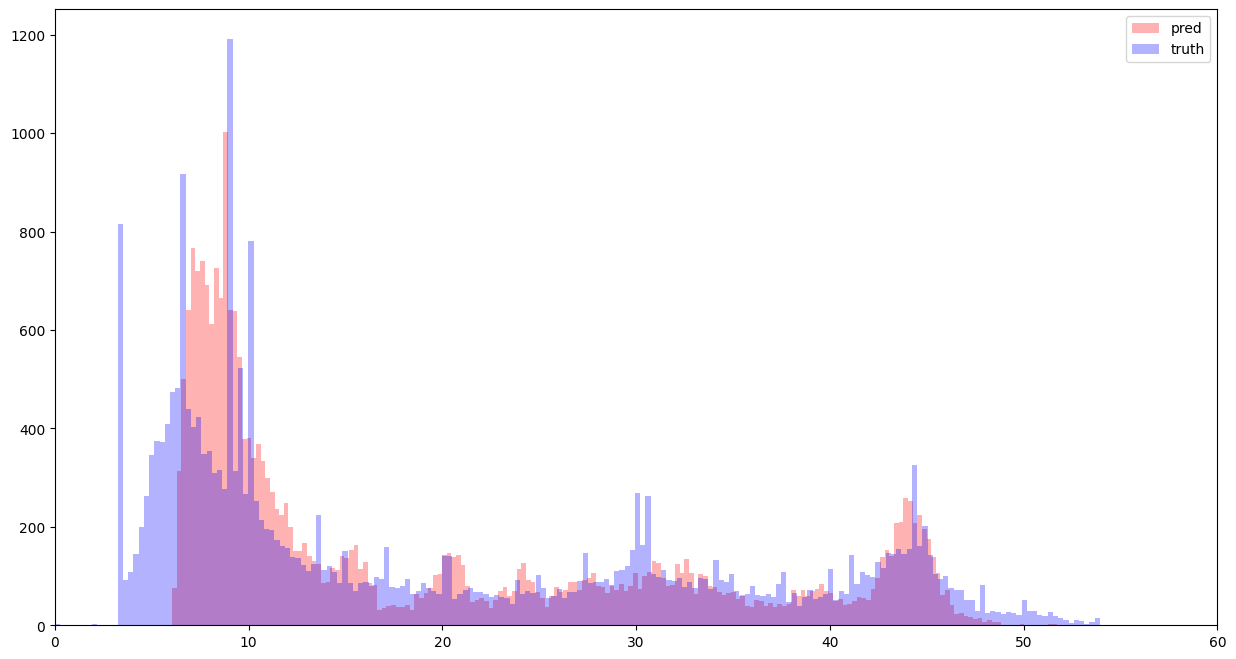

In [53]:
# PLot results

plt.figure(figsize=(15,8))

plt.hist(y_test_pred_nn, label='pred', color='r', bins=200, alpha=0.3)
plt.hist(y_test, label='truth', color='b', bins=200, alpha=0.3)

plt.legend()
plt.xlim((0,60))

plt.show;